# Cellular Automata and Computation

In this workbook I investigate cellular automata visually and using machine learning. In our case cellular automata (CA) will be an array of 'cells' which take some value. The states of the cells will evolve in time based on their neighbors. CA evolution is often greatly simplified by restricting update rules to interactions between nearest or next-to-nearest neighbors.

One obvious problem to investigate is the degree to which the function of a cellular automaton can be modelled using machine learning methods. In the first part I'll begin by generating some cellular automata for viewing.

In [1]:
import numpy as np
import matplotlib.pyplot as pp
%matplotlib inline
#import seaborn

## Cellular Automata Spacetime
A CA spacetime is a matrix with each column representing the evolution of a cell through time. The following function begins with a single array indicating the initial state of the CA universe and constructs the matrix one row at a time by evolving the matrix according to a ruleset.

In [2]:
def generate_spacetime(rule, alive = 15, ca_width=30, ca_duration = 30):
    dead = ca_width-alive
    spacetime = []
    space = np.int64( np.hstack((np.ones(alive), np.zeros(dead))) )
    np.random.shuffle( space )
    spacetime.append( space )

    s0 = list(range(ca_width))
    sl1 = s0[1:] + s0[:1]
    sr1 = s0[-1:] + s0[:-1]


    for time_step in xrange(ca_duration):
        values = 4*spacetime[time_step][sr1] + 2*spacetime[time_step][s0] + 1*spacetime[time_step][sl1]
        space = [] 
        for value in values:
            if (rule >> value) & 0x1:
                space.append(1)
            else:
                space.append(0)
        spacetime.append( np.asarray(space) )

    return np.asmatrix(spacetime)


def generate_spacetime_NNN(rule, alive = 200, ca_width = 400, ca_duration = 400):
    dead = ca_width-alive
    spacetime = []
    space = np.int64( np.hstack((np.ones(alive), np.zeros(dead))) )
    np.random.shuffle( space )
    spacetime.append( space )
    s0 = list(range(ca_width))
    sl3 = s0[3:] + s0[:3]
    sl2 = s0[2:] + s0[:2]
    sl1 = s0[1:] + s0[:1]
    sr1 = s0[-1:] + s0[:-1]
    sr2 = s0[-2:] + s0[:-2]
    sr3 = s0[-3:] + s0[:-3]

    for time_step in range(ca_duration):
        values = 64*spacetime[time_step][sr3] + 32*spacetime[time_step][sr2] + 16*spacetime[time_step][sr1] + 8*spacetime[time_step][s0] + 4*spacetime[time_step][sl1] + 2*spacetime[time_step][sl2] + spacetime[time_step][sl3]
        space = []
        for value in values:
            if ((np.uint64(rule[value//64]) << np.uint64(value % 64)) & 0x8000000000000000):
                space.append(1)
            else:
                space.append(0)
        spacetime.append( np.asarray(space) )

    return np.asmatrix(spacetime)

In [8]:
from matplotlib.colors import ListedColormap

def show_spacetime(spacetime):
    # make a color map of fixed colors
    cmap = ListedColormap(['gold','black'])
    # tell imshow about color map so that only set colors are used
    img = pp.imshow(spacetime,interpolation='nearest',
                    cmap = cmap)
    #pp.colorbar(img,cmap=cmap, ticks=[0,1])
    pp.show()

# Elementary CA examples
First we look at the simple case of CA update rules that only depend on nearest neighboring cells. These 'elementary cellular automata' were classified by Stephen Wolfram who found the 2^3 inputs to each cell meant that each ruleset could be numbered with an 8 digit binary number. This gives 256 different possible rules. The nearest neighbor spacetime generator above takes a number between 0 and 255 and returns a corresponding spacetime.

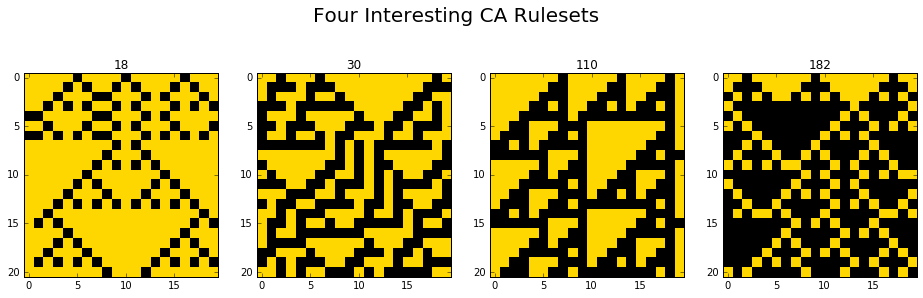

In [7]:

rules = [18, 30, 110, 182]
titles = [str(x) for x in rules]

from matplotlib.colors import ListedColormap
fig, subfigs = pp.subplots(1,4,figsize=(16, 5))
cmap = ListedColormap(['gold','black'])
fig.suptitle('Four Interesting CA Rulesets', fontsize=20)

for i in range(4):
    ax = subfigs[i]
    ax.set_title(titles[i])
    spacetime = generate_spacetime(rules[i],alive = 3, ca_duration = 20, ca_width = 20)
    ax.imshow(spacetime,interpolation='nearest',
                    cmap = cmap)


## Next-to-Nearest-Neighbor CA that solve a particular problem

Now let's look at three spacetimes for CA rulesets which have been found to perform the computational task of identifying whether the spacetime is mostly in the gold or black state.

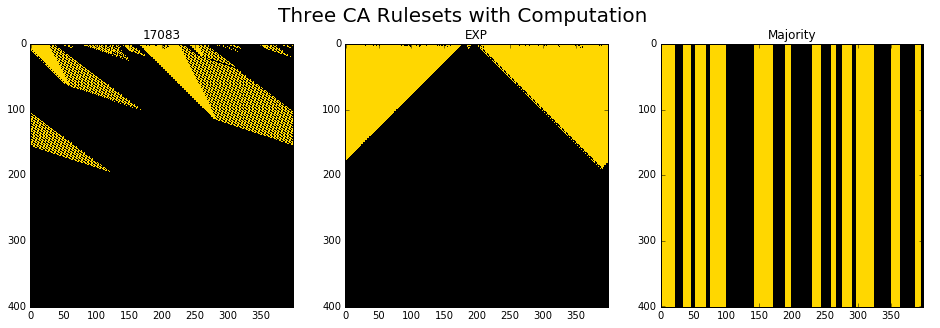

In [8]:
rule_17083 = [0x031001001fa00013, 0x331f9fff5975ffff]
rule_exp = [0x0505408305c90101, 0x200b0efb94c7cff7]
rule_majority = [0x0001011701171777, 0x01171777177f7fff]
rules = [rule_17083, rule_exp, rule_majority]
titles = ['17083', 'EXP', 'Majority']

from matplotlib.colors import ListedColormap
fig, subfigs = pp.subplots(1,3,figsize=(16, 5))
cmap = ListedColormap(['gold','black'])
fig.suptitle('Three CA Rulesets with Computation', fontsize=20)

for i in range(3):
    ax = subfigs[i]
    ax.set_title(titles[i])
    spacetime = generate_spacetime_NNN(rules[i],alive = 200, ca_duration = 400, ca_width = 400)
    ax.imshow(spacetime,interpolation='nearest',
                    cmap = cmap)


One interesting feature of 17083 and EXP is that local information is carried through the spacetime by 'particles' or propagating bits of information that can interact according to some ruleset. There is probably a deeper meaning in this, which we will not get into here.

# Machine Learning with CA

Cellular automata are archetypal patterns, so it's useful to see the qualitative ability for different neural networks to learn CA rulesets. 
If the neural network can reproduce the output of a CA ruleset (given its initial state), then it has inferred the underlying non-linear dynamics. We shall see that neural networks are challenged by such a task.

## Batch Generator
First, let's create a batch generator to dole out spacetime examples to our machine learning models.

In [152]:
def generate(rule, batch_size=10, ca_width=10, memory=0, min_dead=0):
    np.random.randint(ca_width+1)
    while True:
        data = generate_spacetime(rule=rule, 
                               alive = np.random.randint(ca_width+1-min_dead), 
                               ca_width=ca_width,
                               ca_duration = memory+1)
        samples = np.zeros((batch_size, memory+1, ca_width))
        targets = np.zeros((batch_size,1, ca_width))
        for i in range(batch_size):
            samples[i] = data[:-1]
            targets[i] = data[-1][0]
        yield samples, targets

In [106]:
# Testing out the generator
gen110 = generate(110, batch_size=3, memory=0)
next(gen110)

(array([[[ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.]],
 
        [[ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.]],
 
        [[ 0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.]]]),
 array([[ 1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.],
        [ 1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.],
        [ 1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.]]))

In [361]:
def test_predictions(model, generator):
    x,y = next(generator)
    correct_predictions = 0
    for i in range(1000):
        x,y = next(generator)
        ypred = model.predict(x)
        if(np.abs(np.sum(y - ypred)) < 1):
            correct_predictions += 1
        
    print("%d/1000 correct predictions" % correct_predictions)
    
def precise_test(model, generator, tests):
    x,y = next(generator)
    correct_predictions = 0
    for i in range(tests):
        x,y = next(generator)
        ypred = model.predict(x)
        if(np.abs(np.sum(y - ypred)) < 1):
            correct_predictions += 1
        
    print(correct_predictions/np.float32(tests))

## Dense Network
For our first pass attempt, we'll try to train a single fully connected network layer to perform a timestep evolution on a small CA space.

In [329]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam

train_gen110 = generate(110, batch_size=1, memory=0)
val_gen110 = generate(110, batch_size=1, memory=0)


model = Sequential() 
model.add(layers.Dense(10, activation='sigmoid',input_shape=(None, 10)))

model.compile(optimizer=Adam(), loss='binary_crossentropy')
history = model.fit_generator(train_gen110,
                             steps_per_epoch=2**12,
                             epochs=8,
                             validation_data=val_gen110,
                             validation_steps=100,
                             verbose=1)

Epoch 1/8
4096/4096 [==============================] - 7s 2ms/step - loss: 0.6795 - val_loss: 0.6639
Epoch 2/8
4096/4096 [==============================] - 6s 2ms/step - loss: 0.6372 - val_loss: 0.6301
Epoch 3/8
4096/4096 [==============================] - 6s 2ms/step - loss: 0.6273 - val_loss: 0.6103
Epoch 4/8
4096/4096 [==============================] - 7s 2ms/step - loss: 0.6193 - val_loss: 0.6074
Epoch 5/8
4096/4096 [==============================] - 6s 2ms/step - loss: 0.6210 - val_loss: 0.6186
Epoch 6/8
4096/4096 [==============================] - 6s 2ms/step - loss: 0.6180 - val_loss: 0.5994
Epoch 7/8
4096/4096 [==============================] - 6s 2ms/step - loss: 0.6166 - val_loss: 0.6225
Epoch 8/8
4096/4096 [==============================] - 7s 2ms/step - loss: 0.6154 - val_loss: 0.6207


In [330]:
test_predictions(model, val_gen110)

185/1000 correct predictions


## Constraining our search
Looking at the output for the above, we see that our model only occasionally makes a correct prediction. One way to make progress on this problem is to look at a smaller subset of the space of initial inputs - we use the min_dead option to specify a sparse initial state.

In [334]:
train_gen110 = generate(110, batch_size=1, memory=0, min_dead=8)
val_gen110 = generate(110, batch_size=1, memory=0, min_dead=8)


model = Sequential()

model.add(layers.Dense(10, activation='sigmoid',input_shape=(None, 10)))

model.compile(optimizer=Adam(), loss='binary_crossentropy')
history = model.fit_generator(train_gen110,
                             steps_per_epoch=2**11,
                             epochs=8,
                             validation_data=val_gen110,
                             validation_steps=100,
                             verbose=1)

Epoch 1/8
2048/2048 [==============================] - 4s 2ms/step - loss: 0.5335 - val_loss: 0.4211
Epoch 2/8
2048/2048 [==============================] - 3s 2ms/step - loss: 0.3712 - val_loss: 0.3275
Epoch 3/8
2048/2048 [==============================] - 3s 2ms/step - loss: 0.2874 - val_loss: 0.2624
Epoch 4/8
2048/2048 [==============================] - 3s 2ms/step - loss: 0.2263 - val_loss: 0.2007
Epoch 5/8
2048/2048 [==============================] - 3s 2ms/step - loss: 0.1789 - val_loss: 0.1661
Epoch 6/8
2048/2048 [==============================] - 3s 2ms/step - loss: 0.1434 - val_loss: 0.1233
Epoch 7/8
2048/2048 [==============================] - 3s 2ms/step - loss: 0.1119 - val_loss: 0.0977
Epoch 8/8
2048/2048 [==============================] - 3s 2ms/step - loss: 0.0874 - val_loss: 0.0765


In [335]:
test_predictions(model, val_gen110)

1000/1000 correct predictions


## Adding a hidden layer
By reducing ourselves to a smaller set of input states we increased our success rate by a factor of 4. Now let's insert some hidden layers to do some thinking.

In [336]:
train_gen110 = generate(110, batch_size=1, memory=0, min_dead=0)
val_gen110 = generate(110, batch_size=1, memory=0, min_dead=0)

model = Sequential() 

model.add(layers.Dense(80, activation='relu', input_shape=(None, 10)))
model.add(layers.Dense(10, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy')
history = model.fit_generator(train_gen110,
                             steps_per_epoch=2**11,
                             epochs=10,
                             validation_data=val_gen110,
                             validation_steps=100,
                             verbose=1)

Epoch 1/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.5615 - val_loss: 0.4253
Epoch 2/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.3103 - val_loss: 0.1953
Epoch 3/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.1484 - val_loss: 0.0945
Epoch 4/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0678 - val_loss: 0.0426
Epoch 5/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0280 - val_loss: 0.0191
Epoch 6/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0111 - val_loss: 0.0063
Epoch 7/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0042 - val_loss: 0.0025
Epoch 8/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 9/10
2048/2048 [==============================] - 4s 2ms/step - loss: 6.3316e-04 - val_loss: 3.4785e-04
Epoch 10/10
2048/2048 [==============================] - 4s 2ms/step - los

This model seems to have no trouble at all generating correct predictions.

In [337]:
test_predictions(model, val_gen110)

1000/1000 correct predictions


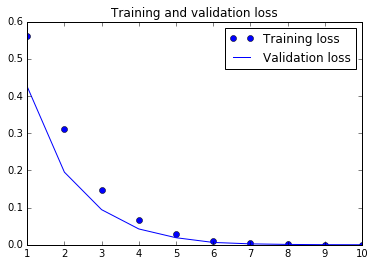

In [338]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = np.arange(1, len(loss)+1)
pp.plot(epochs, loss, 'bo', label='Training loss')
pp.plot(epochs, val_loss, 'b', label='Validation loss')
pp.title('Training and validation loss')
pp.legend()
pp.show()

How small can we make the hidden layer to still have 100% performance? 

In [339]:
train_gen110 = generate(110, batch_size=1, memory=0, min_dead=8)
val_gen110 = generate(110, batch_size=1, memory=0, min_dead=8)

model = Sequential() 

model.add(layers.Dense(10, activation='relu', input_shape=(None, 10)))
model.add(layers.Dense(10, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy')
history = model.fit_generator(train_gen110,
                             steps_per_epoch=2**11,
                             epochs=10,
                             validation_data=val_gen110,
                             validation_steps=100,
                             verbose=1)

Epoch 1/10
2048/2048 [==============================] - 5s 2ms/step - loss: 0.4138 - val_loss: 0.2448
Epoch 2/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.1651 - val_loss: 0.0987
Epoch 3/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0748 - val_loss: 0.0449
Epoch 4/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0366 - val_loss: 0.0168
Epoch 5/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0175 - val_loss: 0.0109
Epoch 6/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0081 - val_loss: 0.0058
Epoch 7/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0035 - val_loss: 0.0025
Epoch 8/10
2048/2048 [==============================] - 4s 2ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/10
2048/2048 [==============================] - 4s 2ms/step - loss: 6.3019e-04 - val_loss: 4.4487e-04
Epoch 10/10
2048/2048 [==============================] - 4s 2ms/step - los

In [340]:
test_predictions(model, val_gen110)

1000/1000 correct predictions


In [345]:
train_gen110 = generate(110, batch_size=1, memory=0, min_dead=8)
val_gen110 = generate(110, batch_size=1, memory=0, min_dead=8)

model = Sequential() 

model.add(layers.Dense(5, activation='relu', input_shape=(None, 10)))
model.add(layers.Dense(10, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy')
history = model.fit_generator(train_gen110,
                             steps_per_epoch=2**12,
                             epochs=10,
                             validation_data=val_gen110,
                             validation_steps=100,
                             verbose=1)
test_predictions(model, val_gen110)

Epoch 1/10
4096/4096 [==============================] - 8s 2ms/step - loss: 0.3983 - val_loss: 0.2456
Epoch 2/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.1935 - val_loss: 0.1630
Epoch 3/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.1251 - val_loss: 0.0938
Epoch 4/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0997 - val_loss: 0.1072
Epoch 5/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0857 - val_loss: 0.0855
Epoch 6/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0779 - val_loss: 0.0893
Epoch 7/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0712 - val_loss: 0.0471
Epoch 8/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0696 - val_loss: 0.1006
Epoch 9/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0705 - val_loss: 0.0942
Epoch 10/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.069

In [348]:
train_gen110 = generate(110, batch_size=1, memory=0, min_dead=8)
val_gen110 = generate(110, batch_size=1, memory=0, min_dead=8)

model = Sequential() 

model.add(layers.Dense(6, activation='relu', input_shape=(None, 10)))
model.add(layers.Dense(10, activation='sigmoid'))

model.compile(optimizer=Adam(), loss='binary_crossentropy')
history = model.fit_generator(train_gen110,
                             steps_per_epoch=2**12,
                             epochs=10,
                             validation_data=val_gen110,
                             validation_steps=100,
                             verbose=1)
test_predictions(model, val_gen110)

Epoch 1/10
4096/4096 [==============================] - 8s 2ms/step - loss: 0.3794 - val_loss: 0.2270
Epoch 2/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.1499 - val_loss: 0.1066
Epoch 3/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0845 - val_loss: 0.0732
Epoch 4/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0562 - val_loss: 0.0418
Epoch 5/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0323 - val_loss: 0.0234
Epoch 6/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0185 - val_loss: 0.0192
Epoch 7/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 8/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 9/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 10/10
4096/4096 [==============================] - 7s 2ms/step - loss: 0.002

In [364]:
precise_test(model, val_gen110, 100000)

1.0


Given that the intermediate layer is smaller than the input and output layers, it's remarkabe that we're able to get 99.999+% accuracy. One topic to explore is using autoencoding to create minimal layers for reproducing multiple CA rulesets.